In [2]:
import pandas as pd
import spacy
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [3]:
nlp = spacy.load('en_core_web_sm')
allowed_specials = ['&', ' ', '`']
path_to_file = "../data/labeled_data_1000rows.csv"
path_to_old_file = "../data/scrpaing_result_raw.csv"


In [4]:
df = pd.read_csv(path_to_file, encoding='utf8', sep='|', nrows=628, header=1, names=['text', 'entities'])
df.astype('string')
df = df.fillna('')
df['entities'] = df['entities'].replace('restaurants', '')
df.head()


,text,entities
0,I will update it periodically as I discover ne...,
1,"It is by no means exhaustive, these are places...",
2,"restaurant details: website , IG I finally mad...",Haut Brion
3,"His cuisine is one of modernity, subtlety and ...",
4,Decidedly French with flourishes…,


### Reformat file
Split rows with multiple sentences into separate rows (explode data). It might yield better results than long paragraphs.

In [ ]:
pd.concat([pd.Series(row['category'], row['text'].split('. ')) for _, row in df.iterrows()])\
    .reset_index().to_csv('../data/labeled_data_1000rows.csv', sep='|', index=False)

Read reformatted scraped dataset.

In [5]:
df['nlp'] = df['text'].apply(nlp)
df.head()

,text,entities,nlp
0,I will update it periodically as I discover ne...,,"(I, will, update, it, periodically, as, I, dis..."
1,"It is by no means exhaustive, these are places...",,"(It, is, by, no, means, exhaustive, ,, these, ..."
2,"restaurant details: website , IG I finally mad...",Haut Brion,"(restaurant, details, :, website, ,, IG, I, fi..."
3,"His cuisine is one of modernity, subtlety and ...",,"(His, cuisine, is, one, of, modernity, ,, subt..."
4,Decidedly French with flourishes…,,"(Decidedly, French, with, flourishes, …)"


### NLTK Porter Stemmer

In [6]:
porter_stemmer = PorterStemmer()
df['porter_stemms'] = df['nlp'].apply(lambda x: [porter_stemmer.stem(word.text) for word in x])


### NLTK Snowball Stemmer

In [7]:
snowball_stemmer = SnowballStemmer(language='english')
df['snowball_stemms'] = df['nlp'].apply(lambda x: [snowball_stemmer.stem(word.text) for word in x])

### SpaCy Lemmatizer

In [8]:
df['spacy_lemmas'] = df['nlp'].apply(lambda x: [word.lemma_ for word in x])

In [9]:
df.head(n=10)

,text,entities,nlp,porter_stemms,snowball_stemms,spacy_lemmas
0,I will update it periodically as I discover ne...,,"(I, will, update, it, periodically, as, I, dis...","[I, will, updat, it, period, as, I, discov, ne...","[i, will, updat, it, period, as, i, discov, ne...","[-PRON-, will, update, -PRON-, periodically, a..."
1,"It is by no means exhaustive, these are places...",,"(It, is, by, no, means, exhaustive, ,, these, ...","[It, is, by, no, mean, exhaust, ,, these, are,...","[it, is, by, no, mean, exhaust, ,, these, are,...","[-PRON-, be, by, no, means, exhaustive, ,, the..."
2,"restaurant details: website , IG I finally mad...",Haut Brion,"(restaurant, details, :, website, ,, IG, I, fi...","[restaur, detail, :, websit, ,, IG, I, final, ...","[restaur, detail, :, websit, ,, ig, i, final, ...","[restaurant, detail, :, website, ,, IG, -PRON-..."
3,"His cuisine is one of modernity, subtlety and ...",,"(His, cuisine, is, one, of, modernity, ,, subt...","[hi, cuisin, is, one, of, modern, ,, subtleti,...","[his, cuisin, is, one, of, modern, ,, subtleti...","[-PRON-, cuisine, be, one, of, modernity, ,, s..."
4,Decidedly French with flourishes…,,"(Decidedly, French, with, flourishes, …)","[decidedli, french, with, flourish, …]","[decid, french, with, flourish, …]","[decidedly, French, with, flourish, …]"
5,"restaurant details: website , IG I am so glad ...",,"(restaurant, details, :, website, ,, IG, I, am...","[restaur, detail, :, websit, ,, IG, I, am, so,...","[restaur, detail, :, websit, ,, ig, i, am, so,...","[restaurant, detail, :, website, ,, IG, -PRON-..."
6,I’ve been waiting 3 years since my first taste...,,"(I, ’ve, been, waiting, 3, years, since, my, f...","[I, ’ve, been, wait, 3, year, sinc, my, first,...","[i, ve, been, wait, 3, year, sinc, my, first, ...","[-PRON-, have, be, wait, 3, year, since, -PRON..."
7,"restaurant details : website , IG It’s now bee...",,"(restaurant, details, :, website, ,, IG, It, ’...","[restaur, detail, :, websit, ,, IG, It, ’s, no...","[restaur, detail, :, websit, ,, ig, it, ’s, no...","[restaurant, detail, :, website, ,, IG, -PRON-..."
8,Alex…,,"(Alex, …)","[alex, …]","[alex, …]","[Alex, …]"
9,"I really liked Viajante when it was around, th...",,"(I, really, liked, Viajante, when, it, was, ar...","[I, realli, like, viajant, when, it, wa, aroun...","[i, realli, like, viajant, when, it, was, arou...","[-PRON-, really, like, Viajante, when, -PRON-,..."


# Topic Modelling

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
topic_count = 4
max_df = 0.9
min_df = 2

In [53]:
cv = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
dtm = cv.fit_transform(df['text'])
dtm

<628x983 sparse matrix of type '<class 'numpy.int64'>'
	with 3779 stored elements in Compressed Sparse Row format>

In [54]:
lda = LatentDirichletAllocation(n_components=topic_count, random_state=2137)
lda.fit_transform(dtm)

array([[0.06393405, 0.06282545, 0.06347876, 0.80976174],
       [0.06426956, 0.06345892, 0.06287559, 0.80939593],
       [0.02561532, 0.92260457, 0.02654301, 0.0252371 ],
       ...,
       [0.03238678, 0.90431401, 0.03156743, 0.03173178],
       [0.0291224 , 0.91422437, 0.02809705, 0.02855618],
       [0.04312612, 0.86831815, 0.04297236, 0.04558337]])

Get 10 most important words for topics

In [47]:
for index, topic in enumerate(lda.components_):
    print(f"Topic {index}")
    for i in topic.argsort()[-10:]:
        print(cv.get_feature_names()[i])

Topic 0
great
flavours
cuisine
dishes
kitchen
chef
dish
restaurant
tom
new
Topic 1
delicious
good
things
london
flavour
meal
day
love
food
like


Get probaility of line belonging to a topic

In [56]:
topic_result = lda.transform(dtm)
topic_result[0].round(2)

array([0.06, 0.06, 0.06, 0.81])

In [57]:
df['topic'] = topic_result.argmax(axis=1)
df.head(n=20)

,text,entities,nlp,porter_stemms,snowball_stemms,spacy_lemmas,topic
0,I will update it periodically as I discover ne...,,"(I, will, update, it, periodically, as, I, dis...","[I, will, updat, it, period, as, I, discov, ne...","[i, will, updat, it, period, as, i, discov, ne...","[-PRON-, will, update, -PRON-, periodically, a...",3
1,"It is by no means exhaustive, these are places...",,"(It, is, by, no, means, exhaustive, ,, these, ...","[It, is, by, no, mean, exhaust, ,, these, are,...","[it, is, by, no, mean, exhaust, ,, these, are,...","[-PRON-, be, by, no, means, exhaustive, ,, the...",3
2,"restaurant details: website , IG I finally mad...",Haut Brion,"(restaurant, details, :, website, ,, IG, I, fi...","[restaur, detail, :, websit, ,, IG, I, final, ...","[restaur, detail, :, websit, ,, ig, i, final, ...","[restaurant, detail, :, website, ,, IG, -PRON-...",1
3,"His cuisine is one of modernity, subtlety and ...",,"(His, cuisine, is, one, of, modernity, ,, subt...","[hi, cuisin, is, one, of, modern, ,, subtleti,...","[his, cuisin, is, one, of, modern, ,, subtleti...","[-PRON-, cuisine, be, one, of, modernity, ,, s...",2
4,Decidedly French with flourishes…,,"(Decidedly, French, with, flourishes, …)","[decidedli, french, with, flourish, …]","[decid, french, with, flourish, …]","[decidedly, French, with, flourish, …]",0
5,"restaurant details: website , IG I am so glad ...",,"(restaurant, details, :, website, ,, IG, I, am...","[restaur, detail, :, websit, ,, IG, I, am, so,...","[restaur, detail, :, websit, ,, ig, i, am, so,...",NaN,1
6,I’ve been waiting 3 years since my first taste...,,"(I, ’ve, been, waiting, 3, years, since, my, f...","[I, ’ve, been, wait, 3, year, sinc, my, first,...","[i, ve, been, wait, 3, year, sinc, my, first, ...",NaN,3
7,"restaurant details : website , IG It’s now bee...",,"(restaurant, details, :, website, ,, IG, It, ’...","[restaur, detail, :, websit, ,, IG, It, ’s, no...","[restaur, detail, :, websit, ,, ig, it, ’s, no...",NaN,1
8,Alex…,,"(Alex, …)","[alex, …]","[alex, …]",NaN,1
9,"I really liked Viajante when it was around, th...",,"(I, really, liked, Viajante, when, it, was, ar...","[I, realli, like, viajant, when, it, wa, aroun...","[i, realli, like, viajant, when, it, was, arou...",NaN,2


In [1]:
for topic_index in range(topic_count):
    topic_row_count = df[df['topic'] == topic_index].count()['text']
    entity_row_count = df[(df['entities'] != '') & (df['topic'] == topic_index)].count()['entities']
    print(f"Topic {topic_index}: {entity_row_count}/{topic_row_count}")


NameError: name 'topic_count' is not defined

None of the found topics cover significant majority of rows containing entity.

In [69]:
for topic_count in [2]:
    for max_df in [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]:
        for min_df in [1, 2, 3, 4]:
            print(f"topic_count:{topic_count} max_df:{max_df} min_df:{min_df}")
            cv = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
            dtm = cv.fit_transform(df['text'])
            lda = LatentDirichletAllocation(n_components=topic_count, random_state=2137)
            lda.fit_transform(dtm)
            topic_result = lda.transform(dtm)
            df['topic'] = topic_result.argmax(axis=1)
            for topic_index in range(topic_count):
                topic_row_count = df[df['topic'] == topic_index].count()['text']
                entity_row_count = df[(df['entities'] != '') & (df['topic'] == topic_index)].count()['entities']
                print(f"Topic {topic_index}: {entity_row_count}/{topic_row_count}")


topic_count:2 max_df:0.6 min_df:1
Topic 0: 34/312
Topic 1: 47/316
topic_count:2 max_df:0.6 min_df:2
Topic 0: 55/307
Topic 1: 26/321
topic_count:2 max_df:0.6 min_df:3
Topic 0: 31/351
Topic 1: 50/277
topic_count:2 max_df:0.6 min_df:4
Topic 0: 30/352
Topic 1: 51/276
topic_count:2 max_df:0.7 min_df:1
Topic 0: 34/312
Topic 1: 47/316
topic_count:2 max_df:0.7 min_df:2
Topic 0: 55/307
Topic 1: 26/321
topic_count:2 max_df:0.7 min_df:3
Topic 0: 31/351
Topic 1: 50/277
topic_count:2 max_df:0.7 min_df:4
Topic 0: 30/352
Topic 1: 51/276
topic_count:2 max_df:0.75 min_df:1
Topic 0: 34/312
Topic 1: 47/316
topic_count:2 max_df:0.75 min_df:2
Topic 0: 55/307
Topic 1: 26/321
topic_count:2 max_df:0.75 min_df:3
Topic 0: 31/351
Topic 1: 50/277
topic_count:2 max_df:0.75 min_df:4
Topic 0: 30/352
Topic 1: 51/276
topic_count:2 max_df:0.8 min_df:1
Topic 0: 34/312
Topic 1: 47/316
topic_count:2 max_df:0.8 min_df:2
Topic 0: 55/307
Topic 1: 26/321
topic_count:2 max_df:0.8 min_df:3
Topic 0: 31/351
Topic 1: 50/277
topic_

Use whitelist and blacklsit to select relevant sentences.

In [75]:
whitelist = [' at ', 'in the', 'crew', 'restaurant', 'residency', 'resident', 'concept', 'launch', 'open', 'chef',
             'acclaimed', 'partnership', 'place', 'priced', 'pricey', 'cafe', 'bar ', 'spot', 'location', 'instagram',
             'affordable', 'food heaven', 'list', 'highlight', 'visit', 'by the', 'I love', 'At ', 'discover']


Use lists on raw text.

In [79]:
TP, TN, FP, FN = 0, 0, 0, 0
for index, row in df.iterrows():
    positive = False
    for word in whitelist:
        if word in row['text'] and row['entities'] != '':
            TP += 1
            positive = True
            break
        if word in row['text'] and row['entities'] == '':
            FP += 1
            positive = True
            break
    if not positive and row['entities'] == '':
        TN += 1
    if not positive and row['entities'] != '':
        FN += 1
        print(row['text'])
print(TP, TN, FP, FN)
array = [[TP, TN],
        [FP, FN]]
plot = make_confusion_matrix(np.array(array),
                      group_names=labels,
                      categories=categories,
                      filename='../plots/raw_text_matrix_prefilter.png')

The last time I wrote about Tokyo tonkatsu, was a back to back post on two of Tokyo’s best – Narikura and Tonta
The Celerisotto…
Corbin & King recorded turnover exceeding £40m in 2018, remaining “strong in a competitive environment”
Accounts lodged with Companies House cover the nine months from […]
In Turkish culture, the term Baraka translates to an old wooden home
2120 W Broadway, Vancouver Tel: (604) 288-2941 Web: http://gyopara.com Instagram @gyopara Advice: No reservations, server will seat you on arrival or take your name for the next table
1426 W 8th Ave, Vancouver Tel:  (604) 800-0211 Web: https://mixxbao.com/ Instagram @mixxbao Specializing in Taiwanese inspired snacks and comfort food dishes, Chef Merry and her team has been making delicious dumplings, soups and sandwiches in this South Granville locale
1739 Robson St, Vancouver Tel: (604) 673-5688 Web: https://noodlearts.com/ Instagram: @noodlearts_vancouver Advice:Open daily for lunch and dinner
509 Main Street, Vancouver 

Use lists on porter stemms.

In [ ]:
whitelist_porter_stemms = [porter_stemmer.stem(word).strip() for word in whitelist]
print(whitelist_porter_stemms)
TP, TN, FP, FN = 0, 0, 0, 0
for index, row in df.iterrows():
    positive = False
    for word in whitelist_porter_stemms:
        if word in row['porter_stemms'] and row['entities'] != '':
            TP += 1
            positive = True
            break
        if word in row['porter_stemms'] and row['entities'] == '':
            FP += 1
            positive = True
            break
    if not positive and row['entities'] == '':
        TN += 1
    if not positive and row['entities'] != '':
        FN += 1
        print(row['porter_stemms'])
print(TP, TN, FP, FN)
array = [[TP, TN],
        [FP, FN]]
plot = make_confusion_matrix(np.array(array),
                      group_names=labels,
                      categories=categories,
                      filename='../plots/porter_matrix_prefilter.png')

Use lists on snowball stemms.

In [ ]:
whitelist_snowball_stemms = [porter_stemmer.stem(word).strip() for word in whitelist]
print(whitelist_snowball_stemms)
TP, TN, FP, FN = 0, 0, 0, 0
for index, row in df.iterrows():
    positive = False
    for word in whitelist_snowball_stemms:
        if word in row['snowball_stemms'] and row['entities'] != '':
            TP += 1
            positive = True
            break
        if word in row['snowball_stemms'] and row['entities'] == '':
            FP += 1
            positive = True
            break
    if not positive and row['entities'] == '':
        TN += 1
    if not positive and row['entities'] != '':
        FN += 1
        print(row['snowball_stemms'])
print(TP, TN, FP, FN)
array = [[TP, TN],
        [FP, FN]]
plot = make_confusion_matrix(np.array(array),
                      group_names=labels,
                      categories=categories,
                      filename='../plots/snowball_matrix_prefilter.png')


Use regexps and other structural characteristics.

In [21]:
def is_relevant(word_list):
    word_list = word_list[1:]
    if any([word[0].isupper() for word in word_list if len(word) > 2]):
        return True
    return False

TP, TN, FP, FN = 0, 0, 0, 0
for index, row in df.iterrows():
    if is_relevant(row['spacy_lemmas']) and row['entities'] != '':
        TP += 1
    elif is_relevant(row['spacy_lemmas']) and row['entities'] == '':
        FP += 1
    elif not is_relevant(row['spacy_lemmas']) and row['entities'] == '':
        TN += 1
    elif not is_relevant(row['spacy_lemmas']) and row['entities'] != '':
        FN += 1
print(TP, TN, FP, FN)
array = [[TP, TN],
        [FP, FN]]
plot = make_confusion_matrix(np.array(array),
                      group_names=labels,
                      categories=categories,
                      filename='../plots/rules_matrix_prefilter.png')

81 342 205 0


Use pretrained NER to prefilter.

In [22]:
def is_relevant(row):
    return bool({ent.label_ for ent in row['nlp'].ents}.intersection({'DATE' ,'ORG', 'PERSON', 'NORP', 'GPE', 'FAC', 'PRODUCT'}))

TP, TN, FP, FN = 0, 0, 0, 0
for index, row in df.iterrows():
    if is_relevant(row) and row['entities'] != '':
        TP += 1
    elif is_relevant(row) and row['entities'] == '':
        FP += 1
    elif not is_relevant(row) and row['entities'] == '':
        TN += 1
    elif not is_relevant(row) and row['entities'] != '':
        print(row['nlp'].ents, [ent.label_ for ent in row['nlp'].ents], row['entities'], row['nlp'].text)
        FN += 1
print(TP, TN, FP, FN)
array = [[TP, TN],
        [FP, FN]]
plot = make_confusion_matrix(np.array(array),
                      group_names=labels,
                      categories=categories,
                      filename='../plots/ner_matrix_prefilter.png')

(10 Heddon Street,) ['TIME'] 10 Heddon Street The restaurant brings the same ethos as appeared at 10 Heddon Street, with nose-to-tail dining and homemade pasta dishes the stars
() [] Ossie’s Lunch The clams were at Ossie’s Lunch
79 300 247 2


Draw confusion matricies.

In [24]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df_cm = pd.DataFrame(array, index = [i for i in "TF"],
                  columns = [i for i in "PN"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)


In [54]:
array = [[TN, FP],
        [FN, TP]]
from prefilter_results_raw import make_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

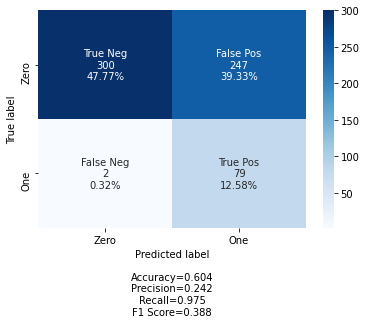

In [56]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
plot = make_confusion_matrix(np.array(array),
                      group_names=labels,
                      categories=categories,
                      filename='../plots/test.png')
























In [55]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          filename=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    filename:      Filename.
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

    if filename:
        plt.savefig(filename)